# Talk2KGs Agentic Tools

In this tutorial, we showcase how to invoke tools of Talk2KnowledgeGraphs via Jupiter Notebook.

As of now, the agent has the following capabilities:
- **Subgraph Extraction**: to extract a subgraph from a knowledge graph provided by the user
- **Subgraph Summarization**: to summarize a subgraph extracted from textualized subgraph obtained from the previous step
- **GraphRAG Reasoning**: to perform reasoning on a subgraph extracted from a knowledge graph by taking into account the context of the subgraph and documents provided by the user

In [ ]:
# Import necessary libraries
import os
import networkx as nx
import openai 
import matplotlib.pyplot as plt
import sys
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
sys.path.append('../../..')
from aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction import SubgraphExtractionTool
from aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization import SubgraphSummarizationTool
from aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning import GraphRAGReasoningTool

#### Set up your API key

Before following this tutorial, make sure that you set up necessary environment variables, especially the API key if you are using LLM models from OpenAI.

You can use the following options to set API key.

##### Option 1 : Retrieve API Key from Environment Variable

In [3]:
# Retrieve API key from environment variable
openai.api_key = os.getenv("OPENAI_API_KEY")

##### Option 2: Store API Key Directly in the Script (Temporary)

In [ ]:
os.environ["OPENAI_API_KEY"] = "your_api_key"
# Make sure to replace "your_api_key" with your actual API key.

### SubgraphExtractionTool

Before invoking the tool, we need to define a dictionary as agent state that will be passed to the tool along with a prompt from user.

In [5]:
# Define the data path
DATA_PATH = "../../../aiagents4pharma/talk2knowledgegraphs/tests/files"
# DATA_PATH = "../../../../data"

# Setup dictionary as agent state
agent_state = {
    "llm_model": ChatOpenAI(model="gpt-4o-mini", temperature=0.0),
    "embedding_model": OpenAIEmbeddings(model="text-embedding-3-small"),
    "uploaded_files": [],
    "topk_nodes": 3,
    "topk_edges": 3,
    "dic_source_graph": [
        {
            "name": "PrimeKG",
            "kg_pyg_path": f"{DATA_PATH}/primekg_ibd_pyg_graph.pkl",
            "kg_text_path": f"{DATA_PATH}/primekg_ibd_text_graph.pkl",
        }
    ],
    "dic_extracted_graph": []
}

# Prepare the prompt for subgraph extraction
prompt = """
    Extract all relevant information related to nodes of genes related to inflammatory bowel disease 
    (IBD) that existed in the knowledge graph.
    Please set the extraction name for this process as `subkg_12345`."""

In [6]:
# Instantiate the SubgraphExtractionTool
subgraph_extraction_tool = SubgraphExtractionTool()

In [7]:
# Invoking the subgraph_extraction_tool
result = subgraph_extraction_tool.invoke(input={"prompt": prompt, 
                                                "tool_call_id": "subgraph_extraction_tool",
                                                "state": agent_state,
                                                "arg_data": {"extraction_name": "subkg_12345"}})

INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Invoking subgraph_extraction tool
INFO:httpx:HTTP Request: GET http://127.0.0.1:11434/api/tags "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


We can check the result of the subgraph extraction tool by two approachs:
- Visualize the extracted subgraph by firstly converting the extracted subgraph to a networkx graph and then visualizing it using matplotlib.
- Print the extracted textualized subgraph.

**Subgraph Visualization**

In [8]:
def dict_to_nx_graph(graph_dict):
    """
    Convert a dictionary representation of a graph to a NetworkX graph.
    """
    # Create a directed graph
    graph = nx.DiGraph()

    # Add nodes with attributes
    for node, attrs in graph_dict["nodes"]:
        graph.add_node(node, **attrs)

    # Add edges with attributes
    for source, target, attrs in graph_dict["edges"]:
        graph.add_edge(source, target, **attrs)

    return graph

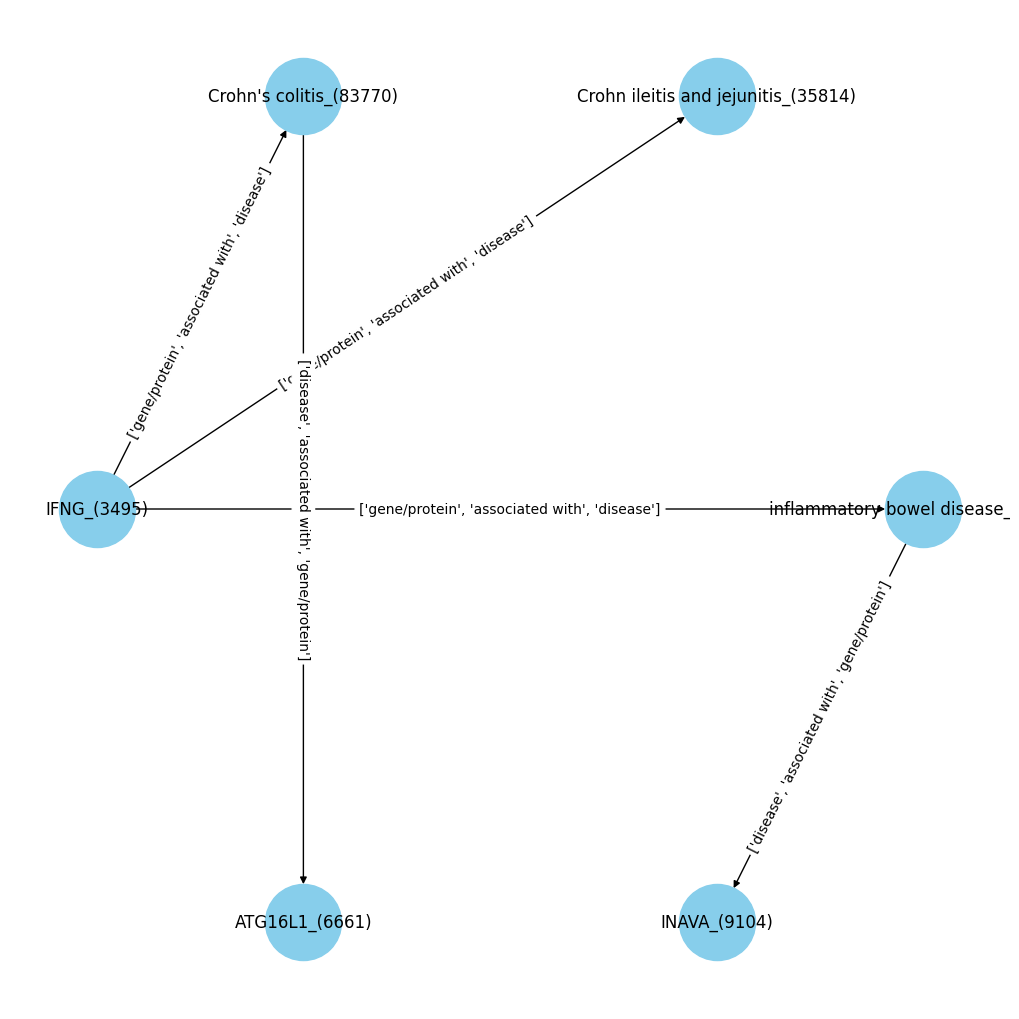

In [9]:
# Extracted subgraph 
nx_graph = dict_to_nx_graph(result.update['dic_extracted_graph'][0]['graph_dict'])

# Visualize the extracted subgraph
# Make a simple plot of the knowledge graph
plt.figure(figsize=(10, 10))
pos = nx.shell_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color='skyblue')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels={(u, v): d['relation'] for u, v, d in nx_graph.edges(data=True)})
plt.show()

**Textualized Subgraph Printing**

In [10]:
# Checking the result of subgraph extraction
print(result.update['dic_extracted_graph'][0]['graph_text'])

node_id,node_attr
IFNG_(3495),"IFNG belongs to gene/protein category. This gene encodes a soluble cytokine that is a member of the type II interferon class. The encoded protein is secreted by cells of both the innate and adaptive immune systems. The active protein is a homodimer that binds to the interferon gamma receptor which triggers a cellular response to viral and microbial infections. Mutations in this gene are associated with an increased susceptibility to viral, bacterial and parasitic infections and to several autoimmune diseases. [provided by RefSeq, Dec 2015]."
ATG16L1_(6661),"ATG16L1 belongs to gene/protein category. The protein encoded by this gene is part of a large protein complex that is necessary for autophagy, the major process by which intracellular components are targeted to lysosomes for degradation. Defects in this gene are a cause of susceptibility to inflammatory bowel disease type 10 (IBD10). Several transcript variants encoding different isoforms have been fou

Lastly, we can store the result of the subgraph extraction in the agent state to be used in the next tutorial for subgraph summarization.

In [11]:
# Store the result of subgraph extraction
agent_state["dic_extracted_graph"] = result.update["dic_extracted_graph"]

In [12]:
# Check current agent state
print(agent_state)

{'llm_model': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7003297ea7b0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x70032971c560>, root_client=<openai.OpenAI object at 0x700428c27a70>, root_async_client=<openai.AsyncOpenAI object at 0x70049d756a80>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), 'embedding_model': OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x70032971ccb0>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x70032971eb40>, model='text-embedding-3-small', dimensions=None, deployment='text-embedding-ada-002', openai_api_version=None, openai_api_base=None, openai_api_type=None, openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tikto

### SubgraphSummarizationTool

In [13]:
# Prepare the prompt for subgraph summarization
prompt = """You are given a subgraph in the forms of textualized subgraph representing
    nodes and edges (triples) obtained from extraction_name `subkg_12345`.
    Summarize the given subgraph and higlight the importance nodes and edges.
    """

In [14]:
# Instantiate the SubgraphSummarizationTool
subgraph_summarization_tool = SubgraphSummarizationTool()

In [15]:
# Invoking the subgraph_summarization_tool
result = subgraph_summarization_tool.invoke(input={"prompt": prompt,
                                                   "extraction_name": "subkg_12345",
                                                   "tool_call_id": "subgraph_summarization_tool",
                                                   "state": agent_state,
                                                   "arg_data": {"extraction_name": "subkg_12345"}})

INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Invoking subgraph_summarization tool for subkg_12345
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


We can check the result of subgraph summarization tool by printing the value of `graph_summary` key in the result.

In [16]:
# Checking the result of subgraph summarization
print(result.update['dic_extracted_graph'][0]['graph_summary'])

The subgraph extracted from `subkg_12345` includes several important nodes and their relationships, primarily focusing on genes/proteins and their associations with inflammatory bowel diseases (IBD) and specific forms of Crohn's disease.

### Key Nodes:
1. **IFNG (Interferon Gamma)**: 
   - Gene/protein that encodes a cytokine involved in immune responses. 
   - Associated with increased susceptibility to various infections and autoimmune diseases, including inflammatory bowel diseases.

2. **ATG16L1**: 
   - Gene/protein essential for autophagy, with defects linked to inflammatory bowel disease type 10 (IBD10).

3. **INAVA**: 
   - Gene/protein involved in cytokine production and intracellular signaling, implicated in inflammatory bowel disease 29.

4. **Inflammatory Bowel Disease (IBD)**: 
   - A disease category that includes conditions caused by mutations in the NOD2 gene.

5. **Crohn Ileitis and Jejunitis**: 
   - A specific form of Crohn's disease affecting the ileum.

6. **Crohn

Afterward, we can store the result of subgraph summarization in the agent state to be used in the final step of the tutorial, which is reasoning.

In [17]:
# Store the result of subgraph summarization in the agent state
agent_state['dic_extracted_graph'][0]["graph_summary"] = result.update['dic_extracted_graph'][0]["graph_summary"]

In [18]:
# Check current agent state
print(agent_state)

{'llm_model': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7003297ea7b0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x70032971c560>, root_client=<openai.OpenAI object at 0x700428c27a70>, root_async_client=<openai.AsyncOpenAI object at 0x70049d756a80>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), 'embedding_model': OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x70032971ccb0>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x70032971eb40>, model='text-embedding-3-small', dimensions=None, deployment='text-embedding-ada-002', openai_api_version=None, openai_api_base=None, openai_api_type=None, openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tikto

### GraphRAGReasoningTool

We would like to perform reasoning on the extracted subgraph and documents to answer a question.

For this purpose, we can set path to each document in the agent state.

In [21]:
# Set path to document
agent_state["uploaded_files"] = [
    {
        "file_name": "adalimumab",
        "file_path": f"{DATA_PATH}/adalimumab.pdf",
        "file_type": "drug_data",
        "uploaded_by": "VPEUser",
        "uploaded_timestamp": "2024-11-05 00:00:00",
    },
]

In [22]:
# Instantiate the GraphRAGReasoningTool
graphrag_reasoning_tool = GraphRAGReasoningTool()

In [23]:
# Prepare the prompt for graph reasoning
prompt = """
Without extracting a new subgraph, based on subgraph extracted from `subkg_12345`
perform Graph RAG reasoning to get insights related to nodes of genes 
mentioned in the knowledge graph related to Adalimumab. 

Here is an additional context:
Adalimumab is a fully human monoclonal antibody (IgG1) 
that specifically binds to tumor necrosis factor-alpha (TNF-α), a pro-inflammatory cytokine.
"""

In [24]:
# Invoking the graphrag_reasoning_tool
result = graphrag_reasoning_tool.invoke(input={"prompt": prompt,
                                               "extraction_name": "subkg_12345",
                                               "tool_call_id": "graphrag_reasoning_tool",
                                               "state": agent_state,
                                               "arg_data": {"extraction_name": "subkg_12345"}})

INFO:aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning:Invoking graphrag_reasoning tool for subkg_12345
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Finally, we can check the result of GraphRAG reasoning tool that taking into accounts extracted subgraph and DrugA document provided by the user.

In [25]:
# Checking the result of graph reasoning
print(result.update["messages"])

[ToolMessage(content='{\'input\': \'\\nWithout extracting a new subgraph, based on subgraph extracted from `subkg_12345`\\nperform Graph RAG reasoning to get insights related to nodes of genes \\nmentioned in the knowledge graph related to Adalimumab. \\n\\nHere is an additional context:\\nAdalimumab is a fully human monoclonal antibody (IgG1) \\nthat specifically binds to tumor necrosis factor-alpha (TNF-α), a pro-inflammatory cytokine.\\n\', \'subgraph_summary\': "The subgraph extracted from `subkg_12345` includes several important nodes and their relationships, primarily focusing on genes/proteins and their associations with inflammatory bowel diseases (IBD) and specific forms of Crohn\'s disease.\\n\\n### Key Nodes:\\n1. **IFNG (Interferon Gamma)**: \\n   - Gene/protein that encodes a cytokine involved in immune responses. \\n   - Associated with increased susceptibility to various infections and autoimmune diseases, including inflammatory bowel diseases.\\n\\n2. **ATG16L1**: \\n  